In [14]:
!pip install pennylane
!pip install torch
!pip install matplotlib
!pip install numpy json os


ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [9]:
!pip install time

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [15]:
!pip install optax
!pip install jax



🔥 Running QAOA on PennyLane — N=12, d=1.5, p=3
• Classical ground energy: -431.2257411850137
• Classical ground config: (1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1)

Iter   0 — Energy = 0.433550
Iter  20 — Energy = 207.254063
Iter  40 — Energy = 34.383160
Iter  60 — Energy = 127.945062
Iter  80 — Energy = 217.605286
Iter 100 — Energy = 10.114303
Iter 120 — Energy = -3.479343
Iter 140 — Energy = 20.214678
Iter 160 — Energy = 68.265186
Iter 180 — Energy = 197.677643

🎯 Final optimized energy: 47.71316807978373
🎯 Classical benchmark:    -431.2257411850137


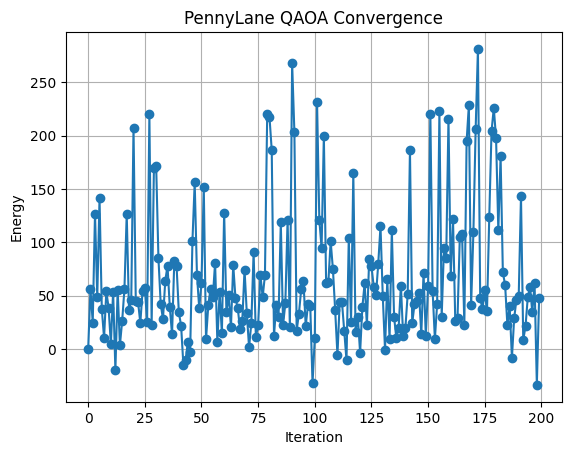

In [14]:
# =====================================================================
#  RANK-BASED ISING — QAOA Implementation using PennyLane
#  Fully Modular - Research Grade - Clean
# =====================================================================

import pennylane as qml
from pennylane import numpy as np
import itertools
import matplotlib.pyplot as plt


# ================================================================
# 1) Classical brute-force ground state (for verification)
# ================================================================

def classical_ground_state(N, d):
    best_E = 1e99
    best_s = None

    for config in itertools.product([1, -1], repeat=N):
        E = 0
        for i in range(N):
            for j in range(i+1, N):
                Jij = (i+1)**d + (j+1)**d
                E += Jij * config[i] * config[j]

        if E < best_E:
            best_E = E
            best_s = config

    return best_E, best_s


# ================================================================
# 2) Build cost Hamiltonian for PennyLane
# ================================================================

def build_cost_hamiltonian(N, d):
    coeffs = []
    ops = []

    for i in range(N):
        for j in range(i+1, N):
            Jij = (i+1)**d + (j+1)**d
            coeffs.append(Jij)
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    return qml.Hamiltonian(coeffs, ops)


# ================================================================
# 3) QAOA Ansatz (advanced custom version)
# ================================================================

def qaoa_layer(gamma, beta, H, N):
    """One layer of QAOA."""
    # Cost: exp(-i γ H_C)
    qml.templates.ApproxTimeEvolution(H, gamma, 1)

    # Mixer: RX rotations
    for i in range(N):
        qml.RX(2 * beta, wires=i)


# ================================================================
# 4) Build full QAOA Circuit
# ================================================================

def build_qaoa_circuit(N, p, H):

    @qml.qnode(qml.device("default.qubit", wires=N), interface="autograd")
    def circuit(params):
        # params contains [gamma_0 ... gamma_p-1, beta_0 ... beta_p-1]
        gammas = params[:p]
        betas = params[p:]

        # Start in |+...+>
        for i in range(N):
            qml.Hadamard(i)

        # Apply layers
        for layer in range(p):
            qaoa_layer(gammas[layer], betas[layer], H, N)

        return qml.expval(H)

    return circuit


# ================================================================
# 5) Run QAOA optimization
# ================================================================

def run_qaoa(N, d, p, max_iter=200):

    print(f"\n🔥 Running QAOA on PennyLane — N={N}, d={d}, p={p}")

    # Classical solution
    classical_E, classical_s = classical_ground_state(N, d)
    print(f"• Classical ground energy: {classical_E}")
    print(f"• Classical ground config: {classical_s}\n")

    # Build quantum Hamiltonian
    H = build_cost_hamiltonian(N, d)

    # Build QAOA circuit
    qaoa = build_qaoa_circuit(N, p, H)

    # Initialize parameters
    params = np.random.uniform(0, np.pi, size=2*p)
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    history = []

    for it in range(max_iter):
        params, energy = opt.step_and_cost(qaoa, params)
        history.append(energy)
        if it % 20 == 0:
            print(f"Iter {it:3d} — Energy = {energy:.6f}")

    print(f"\n🎯 Final optimized energy: {energy}")
    print(f"🎯 Classical benchmark:    {classical_E}")

    return params, history, classical_E, classical_s, H, qaoa


# ================================================================
# Run Example
# ================================================================

if __name__ == "__main__":
    N = 12
    d = 1.5
    p = 3

    params, history, classical_E, classical_s, H, qaoa = run_qaoa(N, d, p)

    # Plot convergence
    plt.plot(history, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.grid(True)
    plt.title("PennyLane QAOA Convergence")
    plt.show()


Building J and classical solution...
Classical ground energy: -431.2257411850137
Classical ground config: [ 1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.]
it    0  E=-425.17556804  overlap=0.000000  lr=0.01250  avgS=0.0000
it   10  E=-428.93818152  overlap=0.000000  lr=0.11642  avgS=0.0009
it   20  E=-324.98927203  overlap=0.000000  lr=1.00000  avgS=0.1051
it   30  E=-227.52708195  overlap=0.000000  lr=1.00000  avgS=0.1609
it   40  E=-353.91731463  overlap=0.000000  lr=1.00000  avgS=0.4173
it   50  E=-396.44432074  overlap=0.000000  lr=1.00000  avgS=0.0369
it   60  E=-403.98872337  overlap=0.000000  lr=1.00000  avgS=0.0152
[it=62] stagnation detected: reduce lr -> 5.000e-01, perturb params
it   70  E=-362.41808021  overlap=0.000000  lr=1.00000  avgS=0.0222
it   80  E=-382.22579650  overlap=0.000000  lr=1.00000  avgS=0.0259
it   90  E=-394.26680869  overlap=0.000000  lr=1.00000  avgS=0.0278
it   99  E=-419.78657024  overlap=0.000000  lr=1.00000  avgS=0.0118
Training done. Time (s): 346

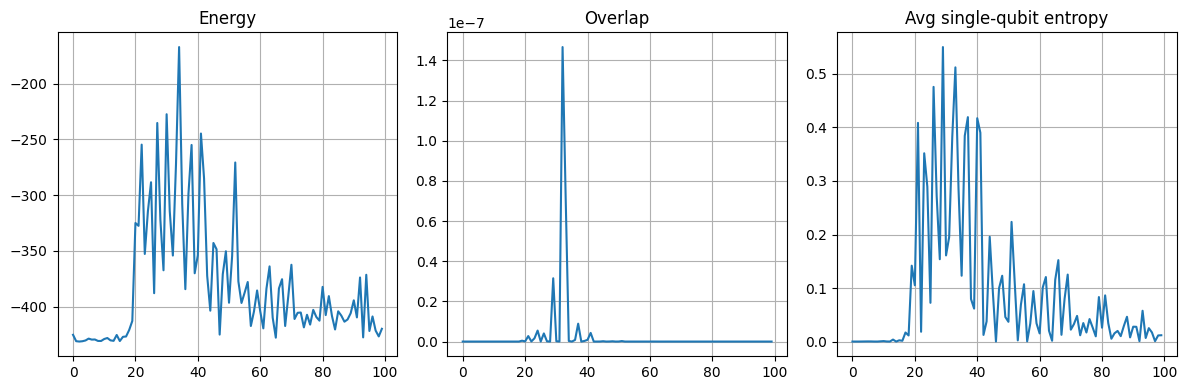

In [18]:
# final_level2_pennylane_torch_qaoa_fixed.py
# PennyLane + Torch QAOA (Level-2 dynamic LR guided by overlap)
# Warm-start from classical solution. Measures overlap + entanglement.
# Saves best params and history to JSON.

import pennylane as qml
from pennylane import numpy as np
import torch
import itertools, time, json, os
import matplotlib.pyplot as plt

# ---------------- User parameters ----------------
N = 12        # start with 6-8; increase to 12 when ready
d = 1.5
p = 3         # QAOA depth (p >= 2 recommended)
max_iters = 100
patience = 60
save_dir = "./qaoa_level2_torch"
os.makedirs(save_dir, exist_ok=True)
device_name = "default.qubit"  # or "lightning.qubit" if installed

# ---------------- Build J (exact same classical model) ----------------
def build_J(N, d):
    J = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(i+1, N):
            J[i, j] = (i+1)**d + (j+1)**d
            J[j, i] = J[i, j]
    return J

# ---------------- Classical brute force ground state ----------------
def classical_ground_state(N, d):
    best_E = np.inf
    best_config = None
    for config in itertools.product([1, -1], repeat=N):
        E = 0.0
        for i in range(N):
            for j in range(i+1, N):
                E += ((i+1)**d + (j+1)**d) * config[i] * config[j]
        if E < best_E:
            best_E = E
            best_config = np.array(config, dtype=float)  # float for Torch interface
    return best_E, best_config

# ---------------- Build PennyLane Hamiltonian (for expectation) ----------------
def build_hamiltonian_from_J(J):
    coeffs = []
    ops = []
    Nloc = J.shape[0]
    for i in range(Nloc):
        for j in range(i+1, Nloc):
            coeffs.append(float(J[i, j]))   # plain Python float
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    H = qml.Hamiltonian(coeffs, ops)
    return H

# ---------------- QNode device + helpers ----------------
dev = qml.device(device_name, wires=N)

def prepare_classical_state(s):
    # s is sequence of +1/-1 (torch or numpy), but should be non-trainable (constants)
    for i, val in enumerate(s):
        # cast val to float (safe because s is not trainable)
        if float(val) < 0:
            qml.PauliX(wires=i)

def qaoa_cost_layer(gamma, J):
    # apply e^{-i * gamma * sum_{i<j} J_ij Z_i Z_j}
    # IsingZZ uses parameter phi with exp(-i * phi/2 * Z_i Z_j)
    # so phi/2 = gamma * J_ij  => phi = 2 * gamma * J_ij
    Nloc = J.shape[0]
    for i in range(Nloc):
        for j in range(i+1, Nloc):
            # gamma is a torch scalar (possibly requires_grad), J[i,j] is float
            theta = 2.0 * gamma * float(J[i, j])
            qml.IsingZZ(theta, wires=[i, j])

def qaoa_mixer_layer(beta):
    for i in range(N):
        qml.RX(2.0 * beta, wires=i)

# Pre-build Hamiltonian (global)
# Use Python floats in H so PennyLane treats it as constant operator
# We'll not recreate H inside QNode to avoid mixing frameworks inside the node.
# H used only with qml.expval(H) which references the prebuilt operator.
# But because QNode is defined below, H must be defined before QNode usage.
# We'll set H later after constructing J.

# QNode returning expectation of H (torch scalar)
@qml.qnode(dev, interface="torch")
def qnode_energy(params, s_init, J):
    # params: torch tensor length 2*p: [gamma0.., beta0..]
    gammas = params[:p]   # torch tensor slice
    betas  = params[p:]   # torch tensor slice
    # prepare warm-start classical state (s_init is torch tensor or numpy arr, constant)
    prepare_classical_state(s_init)
    # layers
    for k in range(p):
        qaoa_cost_layer(gammas[k], J)
        qaoa_mixer_layer(betas[k])
    # expectation of H (we assume H is available in closure)
    return qml.expval(H_global)

# QNode returning statevector and probs for diagnostics
@qml.qnode(dev, interface="torch")
def qnode_state_and_probs(params, s_init, J):
    gammas = params[:p]
    betas  = params[p:]
    prepare_classical_state(s_init)
    for k in range(p):
        qaoa_cost_layer(gammas[k], J)
        qaoa_mixer_layer(betas[k])
    return qml.state(), qml.probs(wires=range(N))

# ---------------- overlap helper ----------------
def s_to_index(s):
    # s: numpy array +1/-1, map +1 -> 0, -1 -> 1; MSB: wire 0 leftmost -> reverse
    bits = [0 if int(x) == 1 else 1 for x in s[::-1]]
    idx = 0
    for b in bits:
        idx = (idx << 1) | b
    return idx

def compute_overlap_from_probs(probs_torch, s_idx):
    return float(probs_torch[s_idx].item())

# ---------------- entanglement measure: single-qubit von Neumann entropy ----------------
def single_qubit_entropy_from_state(state_np, qubit, N):
    psi = state_np.reshape((-1,1))
    rho = psi @ psi.conj().T  # full density matrix
    # partial trace to get 2x2 reduced density for 'qubit'
    def partial_trace(mat, keep, N):
        resh = mat.reshape([2]*(2*N))
        keep_axes = keep
        trace_axes = [i for i in range(N) if i not in keep_axes]
        axes = keep_axes + trace_axes + [i+N for i in keep_axes] + [i+N for i in trace_axes]
        trans = np.transpose(resh, axes)
        k = len(keep_axes)
        kept_dim = 2**k
        traced_dim = 2**(N-k)
        new_shape = (kept_dim, traced_dim, kept_dim, traced_dim)
        mat2 = trans.reshape(new_shape)
        res = np.zeros((kept_dim, kept_dim), dtype=complex)
        for a in range(traced_dim):
            res += mat2[:, a, :, a]
        return res
    rho_red = partial_trace(rho, [qubit], N)
    eigs = np.linalg.eigvalsh(rho_red)
    eigs = np.clip(eigs.real, 0, 1)
    eps = 1e-12
    s = -np.sum(eigs * np.log2(eigs + eps))
    return float(s)

# ---------------- dynamic LR rule ----------------
def update_lr(lr, p_star):
    if p_star < 0.01:
        lr *= 1.25
    elif p_star < 0.1:
        lr *= 1.05
    elif p_star < 0.5:
        lr *= 0.95
    else:
        lr *= 0.8
    lr = min(max(lr, 1e-6), 1.0)
    return lr

# ---------------- Main training pipeline ----------------
def train_level2_torch(N, d, p, max_iters=400, patience=60, lr0=1e-2):
    global H_global
    print("Building J and classical solution...")
    J = build_J(N, d)
    E_classical, s_star = classical_ground_state(N, d)
    print("Classical ground energy:", E_classical)
    print("Classical ground config:", s_star)

    # Build global Hamiltonian with python floats (no torch/autograd)
    H_global = build_hamiltonian_from_J(J)

    s_idx = s_to_index(s_star)

    # initial params warm-start (torch param)
    Jmax = np.max(np.abs(J))
    gamma0 = 0.05 / (Jmax if Jmax > 0 else 1.0)
    beta0 = 0.02
    init = np.array([gamma0]*p + [beta0]*p, dtype=float)
    params = torch.tensor(init, dtype=torch.float64, requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=lr0)

    lr = lr0
    best = {"energy": float("inf"), "params": None, "overlap": 0.0, "entropy": None}
    history = []
    no_improve = 0
    t0 = time.time()

    # Convert s_star to torch tensor constant to pass to QNode (non-trainable)
    s_star_torch = torch.tensor(s_star, dtype=torch.float64)

    for it in range(max_iters):
        optimizer.zero_grad()
        # forward: energy (torch scalar)
        energy_t = qnode_energy(params, s_star_torch, J)
        loss = energy_t
        # backprop
        loss.backward()
        optimizer.step()

        # readjust lr by overlap guidance AFTER step
        state_t, probs_t = qnode_state_and_probs(params, s_star_torch, J)
        overlap = compute_overlap_from_probs(probs_t, s_idx)
        lr = update_lr(lr, overlap)
        for g in optimizer.param_groups:
            g['lr'] = lr

        # compute entanglement measures from state (convert to numpy)
        state_np = state_t.detach().cpu().numpy()
        entropies = [single_qubit_entropy_from_state(state_np, q, N) for q in range(N)]
        avg_entropy = float(np.mean(entropies))

        energy_val = float(energy_t.detach().item())

        history.append({"iter": it, "energy": energy_val, "overlap": overlap, "lr": lr, "avg_entropy": avg_entropy})

        # track best by energy (then by overlap)
        if energy_val < best["energy"] - 1e-12 or (abs(energy_val - best["energy"]) < 1e-12 and overlap > best["overlap"]):
            best.update({"energy": energy_val, "params": params.clone().detach().cpu().numpy().tolist(), "overlap": overlap, "entropy": avg_entropy})
            no_improve = 0
        else:
            no_improve += 1

        if it % 10 == 0 or it == max_iters-1:
            print(f"it {it:4d}  E={energy_val:.8f}  overlap={overlap:.6f}  lr={lr:.5f}  avgS={avg_entropy:.4f}")

        # stagnation handling
        if no_improve >= patience:
            lr *= 0.5
            for g in optimizer.param_groups:
                g['lr'] = lr
            with torch.no_grad():
                params.add_(torch.randn_like(params) * 1e-3)
            no_improve = 0
            print(f"[it={it}] stagnation detected: reduce lr -> {lr:.3e}, perturb params")

        # early stopping if match classical energy
        if abs(energy_val - E_classical) < 1e-8:
            print(f"Converged to classical energy at iteration {it}")
            break

    t1 = time.time()
    print("Training done. Time (s):", t1 - t0)

    out = {
        "N": N, "d": d, "p": p, "classical_energy": float(E_classical),
        "classical_config": s_star.tolist(),
        "best": best,
        "history": history
    }

    fname = os.path.join(save_dir, f"level2_torch_N{N}_d{d}_p{p}.json")
    with open(fname, "w") as f:
        json.dump(out, f, indent=2)
    print("Saved run to", fname)
    return out

# ---------------- Run training ----------------
if __name__ == "__main__":
    res = train_level2_torch(N, d, p, max_iters=max_iters, patience=patience, lr0=1e-2)
    # quick plots
    hist = res["history"]
    its = [h["iter"] for h in hist]
    Es = [h["energy"] for h in hist]
    Ovs = [h["overlap"] for h in hist]
    Ss = [h["avg_entropy"] for h in hist]
    LRs = [h["lr"] for h in hist]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.plot(its, Es); plt.title("Energy"); plt.grid(True)
    plt.subplot(1,3,2); plt.plot(its, Ovs); plt.title("Overlap"); plt.grid(True)
    plt.subplot(1,3,3); plt.plot(its, Ss); plt.title("Avg single-qubit entropy"); plt.grid(True)
    plt.tight_layout()
    plt.show()
